In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

headers = ['user_id', 'movie_id', 'rating', 'time']
data = pd.read_table('ml-100k/u.data', sep='\t', header=None, names=headers)

In [70]:
print(len(data))
data.head()

100000


,user_id,movie_id,rating,time
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [71]:
user = data['user_id'].values
movie = data['movie_id'].values
rating = data['rating'].values

In [72]:
def build_R(user, movie, rating):
    R = np.zeros((943,1682),dtype=int)
    for i in range(len(user)):
        R[user[i]-1, movie[i]-1] = rating[i]
    return R

In [74]:
R = build_R(user, movie, rating)
W = (R!=0)
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)

In [10]:
def get_error(R, U, V, W):
    return np.sum((W * (R - np.dot(U, V))**2))

In [75]:
print(R.shape)
R

(943, 1682)


array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

# Part 1 (No Cross Validation)

min error: 518683.176939


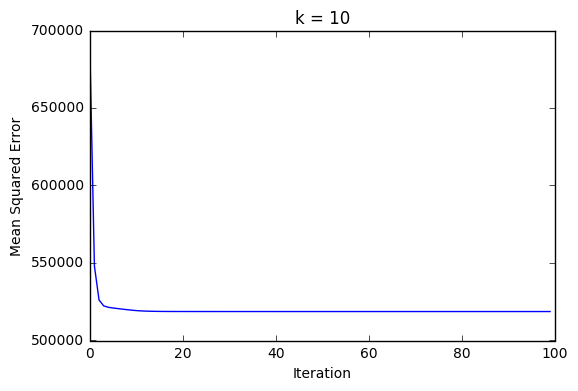

min error: 344333.906797


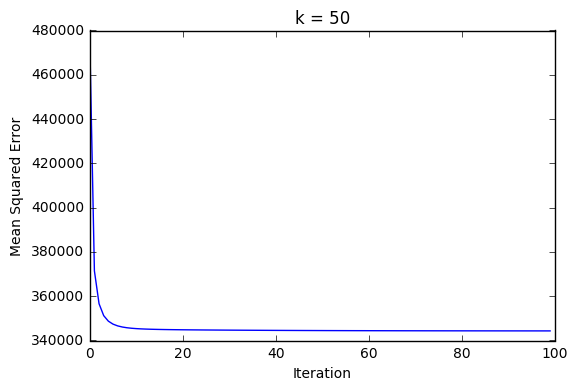

min error: 228798.648142


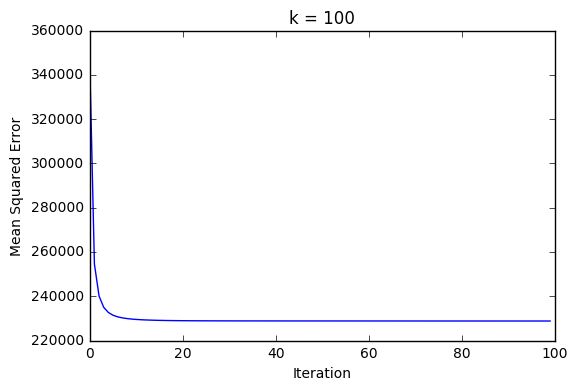

min error: 7331.29696816


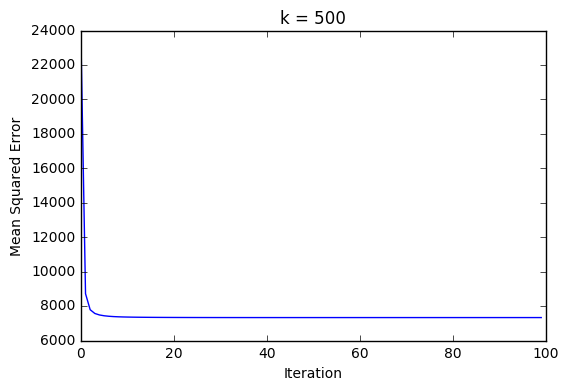

In [76]:
m, n = R.shape
n_iterations = 100
min_error = np.inf
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
        V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
        error = get_error(R, U, V, W)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print("min error:", min_error)
    plt.plot(errors)
    plt.title("k = %d" % k)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Iteration")
    plt.show()

In [77]:
R_hat-=np.min(R_hat)
R_hat *= float(5) / np.max(R_hat)
R_hat

array([[ 4.61761191,  3.08806605,  3.76981769, ...,  0.70062249,
         0.69712721,  0.72176527],
       [ 3.80702322,  0.76323896,  0.95565804, ...,  0.68422088,
         0.72433595,  0.7216654 ],
       [ 0.72739061,  0.76007366,  0.7442967 , ...,  0.74398937,
         0.73406636,  0.68265824],
       ..., 
       [ 4.59450869,  0.68524168,  0.68930759, ...,  0.71431909,
         0.70311864,  0.71630278],
       [ 0.71923845,  0.99328013,  0.76144533, ...,  0.70216657,
         0.7217551 ,  0.69615641],
       [ 0.66056538,  4.52062393,  0.82329408, ...,  0.73549986,
         0.75135778,  0.69727298]])

# Part 2 (Cross Validation)

In [78]:
def plot_roc(r_hat, r, k, lmbda):
    tp = 0  # true positive
    fp = 0  # false positive
    fn = 0  # false negative

    threshold_value = np.arange(1,6,1)
    precision = np.zeros(len(threshold_value))
    recall = np.zeros(len(threshold_value))

    for i, t in enumerate(threshold_value):
        tp = np.sum(r[r_hat >= t] >= t)
        fp = np.sum(r[r_hat >= t] < t)
        fn = np.sum(r[r_hat < t] >= t)

        precision[i] = tp / float(tp+fp)  # calculating precision
        recall[i] = tp / float(tp+fn)  # calculating recall

    plt.figure(1)
    plt.ylabel('Recall')
    plt.xlabel('Precision')
    plt.title('ROC Curve k={0} lambda={1}'.format(k,lmbda))
    plt.scatter(precision, recall, s=60, marker='o')
    plt.plot(precision,recall)
    plt.show()

In [79]:
from sklearn.model_selection import KFold

# 10-fold cross validation
m, n = R.shape
n_iterations = 100
kf = KFold(n_splits=10, shuffle=True, random_state=50)

for k in (10, 50, 100, 500):
    count = 1
    v_errors = []
    for train_index,test_index in kf.split(data):
        train = data.as_matrix()[train_index]
        test = data.as_matrix()[test_index]
        W = (R!=0)
        W[W == True] = 1
        W[W == False] = 0
        # To be consistent with our Q matrix
        W = W.astype(np.float64, copy=False)

        for i in range(len(train_index)):
            W[train[i][0] - 1, train[i][1] - 1] = 1

        U = 5 * np.random.rand(m, k) 
        V = 5 * np.random.rand(k, n)
        errors = []
        min_error = np.inf
        for it in range(n_iterations):
            U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
            V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
            error = get_error(R, U, V, W)                
            errors.append(error)
            if error<min_error:
                min_error = error
                min_test = test
                R_hat = np.dot(U, V)

        R_hat -= np.min(R_hat)
        R_hat *= float(5) / np.max(R_hat)

        v_error = 0
        for j in range(len(test_index)):
            v_error += np.absolute(test[j][2]-R_hat[test[j][0]-1, test[j][1]-1])

        print("k=%d, average error of test %d:%f"%(k, count, v_error/len(test_index)))
        v_errors.append(v_error)
        count += 1
    print("average error of k=%d system:%f"%(k, sum(v_errors)/10))

k=10, average error of test 1:1.779198
k=10, average error of test 2:1.775935
k=10, average error of test 3:1.806421
k=10, average error of test 4:1.767226
k=10, average error of test 5:1.777916
k=10, average error of test 6:1.778957
k=10, average error of test 7:1.770516
k=10, average error of test 8:1.797834
k=10, average error of test 9:1.787231
k=10, average error of test 10:1.783259
average error of k=10 system:17824.491882
k=50, average error of test 1:1.228441
k=50, average error of test 2:1.215962
k=50, average error of test 3:1.227850
k=50, average error of test 4:1.250989
k=50, average error of test 5:1.236055
k=50, average error of test 6:1.192890
k=50, average error of test 7:1.275598
k=50, average error of test 8:1.268268
k=50, average error of test 9:1.263077
k=50, average error of test 10:1.209610
average error of k=50 system:12368.739906
k=100, average error of test 1:1.215550
k=100, average error of test 2:1.173758
k=100, average error of test 3:1.198052
k=100, average

Precision: 0.999981
Recall: 0.149215


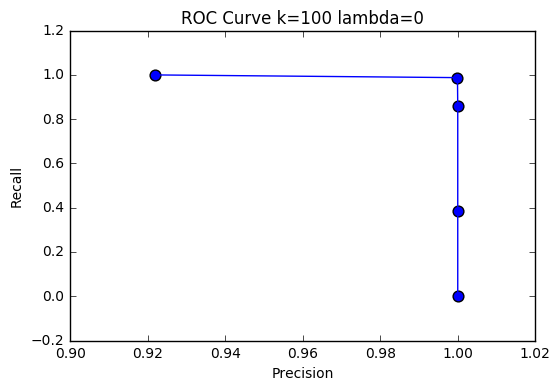

In [80]:
# calculating precision: percentage of your correct prediction
like_predict = np.where(R_hat>3.5)
like_actual = np.where(R[like_predict]>3.5)
print("Precision: %f" %(len(like_actual[0])/len(like_predict[0])))

# calculating recall: percentage of correctly predicted test data
like_actual = np.where(min_test>3.5)
like_predict = 0
for i in range(len(min_test)):
    if R[min_test[i,0]-1, min_test[i,1]-1]>3.5 and R_hat[min_test[i,0]-1, min_test[i,1]-1]>3.5:
        like_predict += 1

print("Recall: %f" %(like_predict/len(like_actual[0])))  

plot_ROC_curve(R_hat, R, 100, 0)

# Part 4 - interchange weight/rating matrix

In [81]:
W_1 = R.copy()
R_1 = W.copy()

In [82]:
m, n = R_1.shape
n_iterations = 100
min_error = np.inf
lmbda = 0.1
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R_1.T)).T
        V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R_1)) 
        error = get_error(R_1, U, V, W_1)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print ("Leasted Squared error when K = %d: %f"%(k, min_error))

Leasted Squared error when K = 10: 128481.593871
Leasted Squared error when K = 50: 86858.433937
Leasted Squared error when K = 100: 59114.433749
Leasted Squared error when K = 500: 2068.510783


# Part 4 - regularization

error for k = 10, lambda = 0.01: 519999.034100


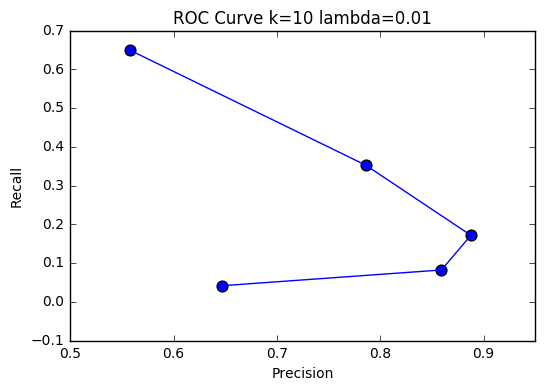

error for k = 10, lambda = 0.10: 520642.430325


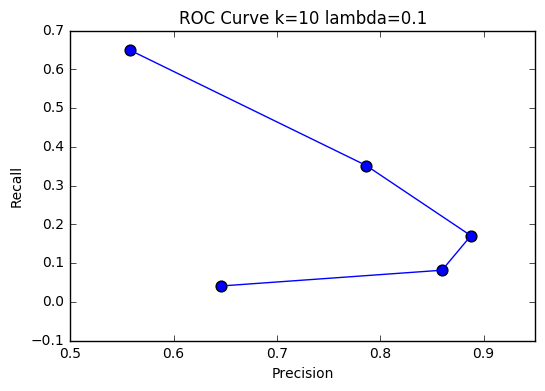

error for k = 10, lambda = 1.00: 521140.376344


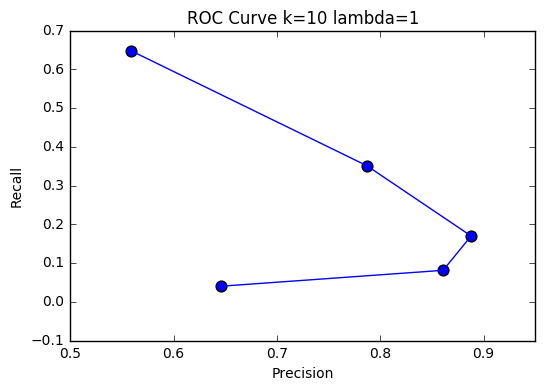

error for k = 50, lambda = 0.01: 345581.794379


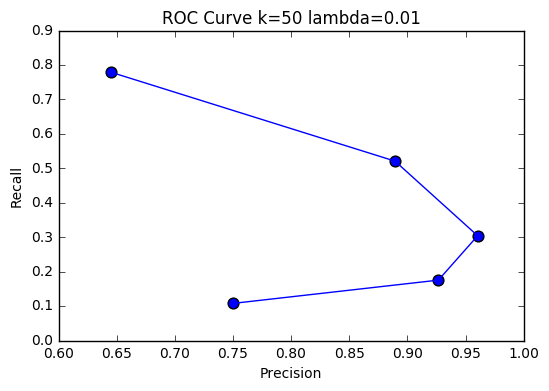

error for k = 50, lambda = 0.10: 346138.404393


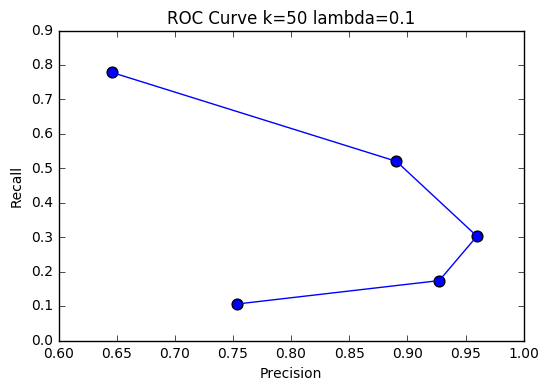

error for k = 50, lambda = 1.00: 347477.682263


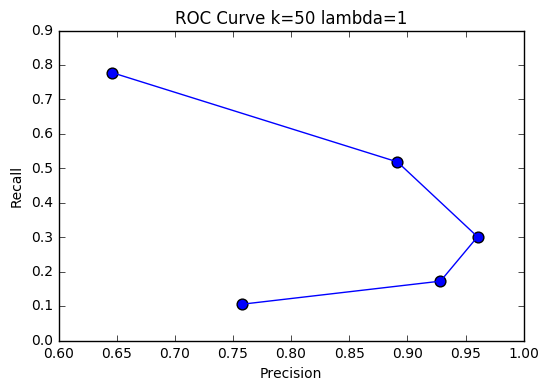

error for k = 100, lambda = 0.01: 229752.648200


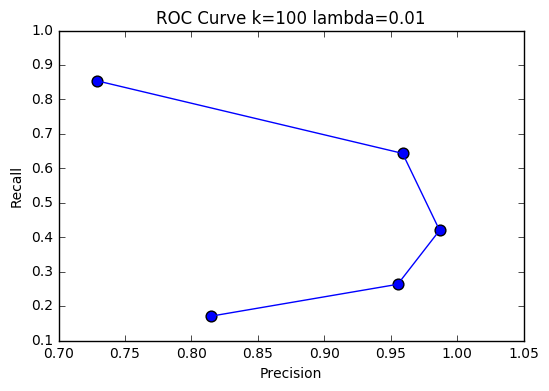

error for k = 100, lambda = 0.10: 230280.432163


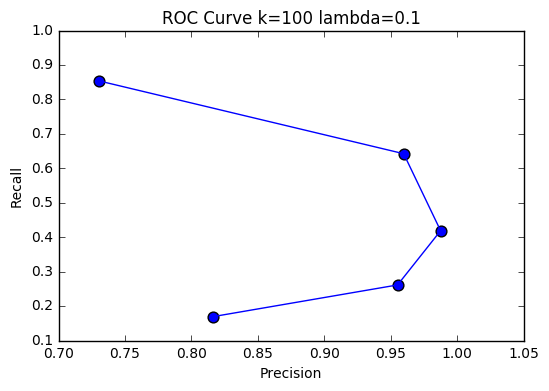

error for k = 100, lambda = 1.00: 232143.684585


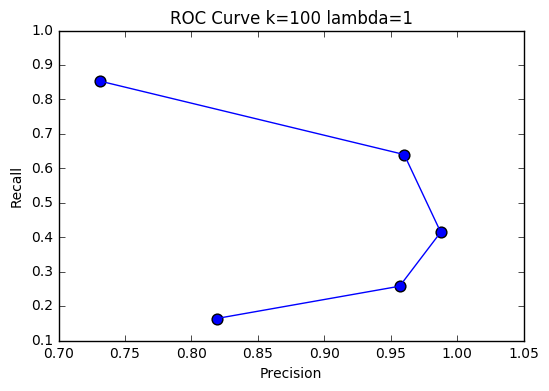

In [83]:
m, n = R.shape
n_iterations = 100
min_error = np.inf
for k in (10, 50, 100):
    for lmbda in (0.01, 0.1, 1):
        U = 5 * np.random.rand(m, k)
        V = 5 * np.random.rand(k, n)
        errors = []
        for it in range(n_iterations):
            U = np.linalg.solve(np.dot(V, V.T) + lmbda * np.eye(k), np.dot(V, R.T)).T
            V = np.linalg.solve(np.dot(U.T, U) + lmbda * np.eye(k), np.dot(U.T, R)) 
            error = get_error(R, U, V, W)                
            errors.append(error)

        R_hat = np.dot(U, V)
        print("error for k = %d, lambda = %.2f: %f"%(k, lmbda, error))
        
        # plot roc curve
        plot_roc(R_hat, R, k, lmbda)

# Part 5

In [84]:
# 10-fold cross validation
m, n = R.shape
n_iterations = 100
kf = KFold(n_splits=10, shuffle=True, random_state=50)
k = 100
lmbda = 0.01

count = 1
v_errors = []
L = 5
threshold = 3
top_movies = []
hit_cross_val = []
alarm_cross_val = []
total_cross_val = []
precision_cross_val = []

for train_index,test_index in kf.split(data):
    test = data.as_matrix()[test_index]
    
    R_train = W.copy()
    W_train = R.copy()

    # set to 0 if data point is in test set
    for i in range(len(test_index)):
        W_train[test[i][0] - 1, test[i][1] - 1] = 0

    U = 5 * np.random.rand(m, k) 
    V = 5 * np.random.rand(k, n)
    errors = []
    min_error = np.inf
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T) + lmbda * np.eye(k), np.dot(V, R_train.T)).T
        V = np.linalg.solve(np.dot(U.T, U) + lmbda * np.eye(k), np.dot(U.T, R_train)) 
        error = get_error(R_train, U, V, W_train)                
        errors.append(error)
        if error<min_error:
            min_error = error
            min_test = test
            R_hat = np.dot(U, V)

    R_hat -= np.min(R_hat)
    R_hat *= float(5) / np.max(R_hat)
    
    # ignore entries without actual rating
    R_hat[R_train == 0] = -1 
  
    hit_val=[0,0,0,0,0]
    total_val=[0,0,0,0,0]
    alarm_val=[0,0,0,0,0]
    precision_val=[]
    
    for l in range(1,(L+1)):
        tp = 0
        fp = 0
        
        for i in range(m):
            
            movie_indices = np.argsort(R_hat[i])[-l:]
            for j in range(len(movie_indices)):
                pred_rating = R_hat[i][movie_indices[j]] # predicted rating
                act_rating = R[i][movie_indices[j]] # actual rating
                if pred_rating < 0:
                    continue
                if pred_rating > threshold: # predicted like
                    if act_rating > threshold:
                        hit_val[j] += 1
                        total_val[j] += 1
                        tp += 1
                    else:
                        fp += 1
                        alarm_val[j] += 1
                        total_val[j] += 1
                        
        precision_val.append(tp / float(tp+fp))

    hit_cross_val.append(hit_val)
    alarm_cross_val.append(alarm_val)
    precision_cross_val.append(precision_val)
    total_cross_val.append(total_val)  
precision = np.sum(precision_cross_val,axis=0)
hits = np.sum(hit_cross_val,axis=0)
miss = np.sum(alarm_cross_val,axis=0)
total = np.sum(total_cross_val,axis=0)

hits = hits / (total.astype(float))
miss = miss / (total.astype(float))
precision = precision / 10.0   
    
print("Precision: {0}".format(precision))
print("Hits: {0}".format(hits))
print("Miss: {0}".format(miss))

Precision: [ 0.72046358  0.70789443  0.70070985  0.70184534  0.69816254]
Hits: [ 0.69814481  0.70183264  0.70071959  0.70789549  0.72046626]
Miss: [ 0.30185519  0.29816736  0.29928041  0.29210451  0.27953374]


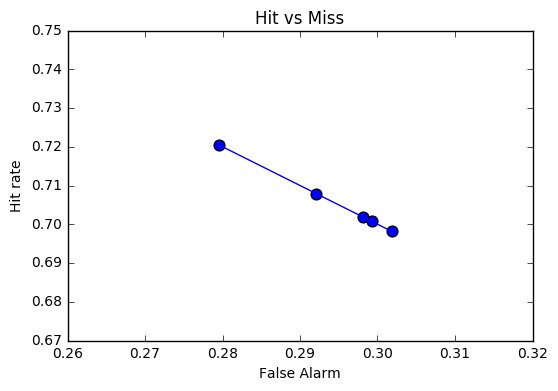

In [85]:
plt.figure(1)
plt.ylabel('Hit rate')
plt.xlabel('False Alarm')
plt.title('Hit vs Miss')
plt.scatter(miss, hits, s=60, marker='o')
plt.plot(miss,hits)
plt.show()